# Duke PAM Project - Undersampled PAM
## Title: Showing Examples of Data Augmentation Results
## Author: Anthony DiSpirito III
## Github: @axd465
## Date: November 20, 2020

### pip installs/uninstalls

In [1]:
# !pip3 uninstall tensorflow_datasets -y -q
# !pip3 install git+git://github.com/axd465/datasets -q

### Import Statements

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import os
import shutil
from functools import partial
from tensorflow.image import random_crop, random_brightness, random_contrast, \
                             random_flip_left_right, random_flip_up_down, resize
if os.path.basename(os.getcwd()) == 'examples':
    os.chdir('../')
from utils.downsampling_utils import *
from utils.augmentation_utils import *

%matplotlib inline
%load_ext autoreload
%autoreload 2
AUTOTUNE = os.cpu_count()//2 #tf.data.experimental.AUTOTUNE
print('Tensorflow version: ' + tf.__version__)

Tensorflow version: 2.3.1


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Load Dataset

In [3]:
(train_ds, val_ds), metadata = tfds.load('duke_pam/clean', split=['train', 'validation'], with_info=True, data_dir = 'data')

## Data Augmentation Pipeline

### Setting Augmentation Parameters

In [4]:
CROP_SIZE = (128, 128, 3)
rand_crop = partial(random_crop, size = CROP_SIZE)

In [5]:
PROB_OF_AUG = 1/3 # prob [0,1]
MAX_BRIGHT_SHIFT = 0.1 # in range [0,1]
LOWER_CONTRAST_FACTOR = 0.2
UPPER_CONTRAST_FACTOR = 1.8
GAUSS_NOISE_MEAN = 0
LOWER_GAUSS_NOISE_STD = 0.003
UPPER_GAUSS_NOISE_STD = 0.015
main_augment = partial(augment, prob = PROB_OF_AUG, max_shift = MAX_BRIGHT_SHIFT, 
                       lower_con_factor = LOWER_CONTRAST_FACTOR, upper_con_factor = UPPER_CONTRAST_FACTOR,
                       mean = GAUSS_NOISE_MEAN, std_lower = LOWER_GAUSS_NOISE_STD, 
                       std_upper = UPPER_GAUSS_NOISE_STD)

In [6]:
MAX_SHIFT_FRACTION_X_Y = [0.1, 0.1]
FILL_MODE = 'constant'
INTERP_ORD = 0 # No Interp

lambda_map_func = partial(keras_augment, fill_mode=FILL_MODE, interpolation_order=INTERP_ORD, 
                  max_width_shift = MAX_SHIFT_FRACTION_X_Y[0], max_height_shift = MAX_SHIFT_FRACTION_X_Y[1])
lambda_func = lambda x: tf.numpy_function(lambda_map_func, [x], tf.float32)

## Uniform Downsampling Method

In [7]:
DOWNSAMPLING_METHOD = 'uniform'
DOWN_RATIO = (3,3)

down_map_func = partial(downsample_zerofill, down_ratio=DOWN_RATIO, min_shape = (CROP_SIZE[0], CROP_SIZE[1]))
train_ds_down_zerofill = train_ds.map(lambda x: tf.numpy_function(down_map_func, [x['image']], tf.float32), num_parallel_calls=AUTOTUNE).cache()
val_ds_down_zerofill = val_ds.map(lambda x: tf.numpy_function(down_map_func, [x['image']], tf.float32), num_parallel_calls=AUTOTUNE).cache()

train_ds_aug = (
    train_ds_down_zerofill
    .map(rand_crop, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
    .map(main_augment, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
    .map(lambda_func, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)
val_ds_aug = (
    val_ds_down_zerofill
    .map(rand_crop, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
) 

### Showing Augmentation Result

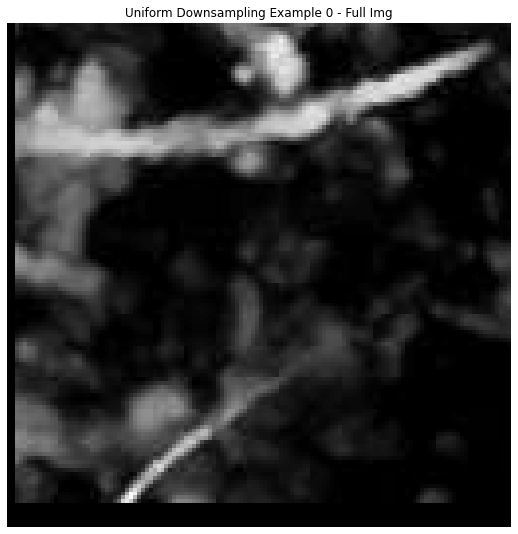

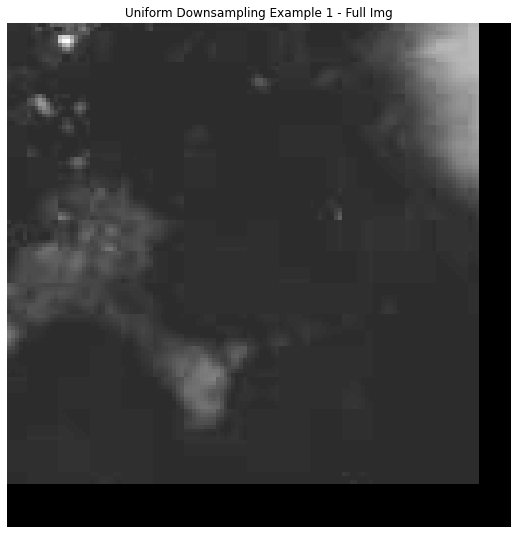

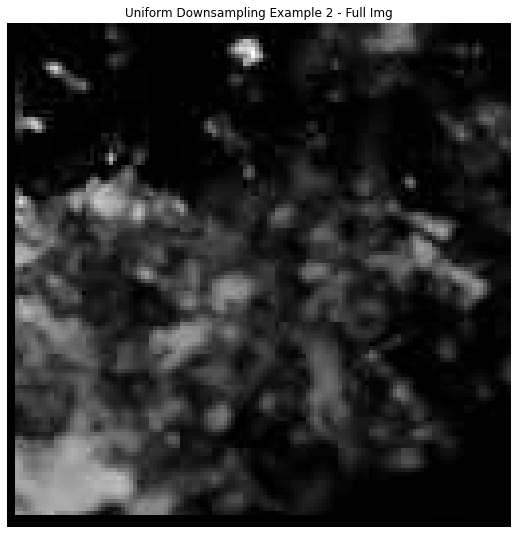

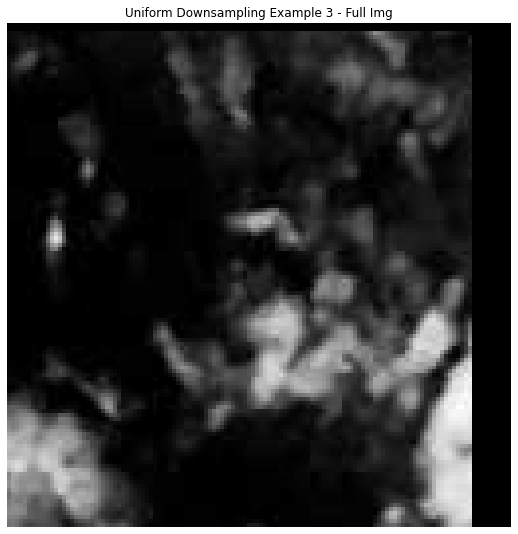

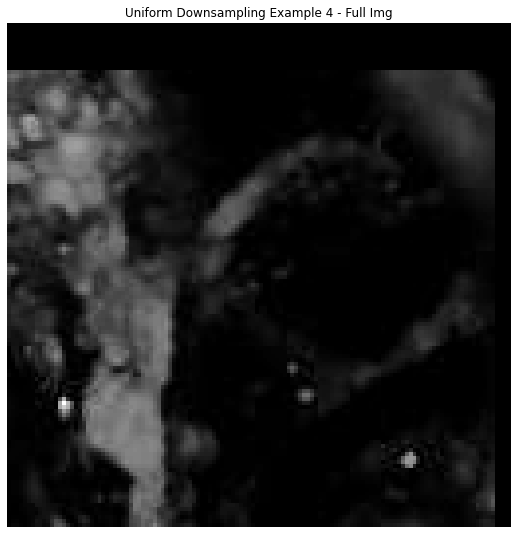

In [8]:
for i in range(5):
    img = (next(iter(train_ds_aug)))[...,0]
    figsize = (7,7)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(img, cmap = 'gray')
    plt.title(f'Uniform Downsampling Example {i} - Full Img')
    plt.show()

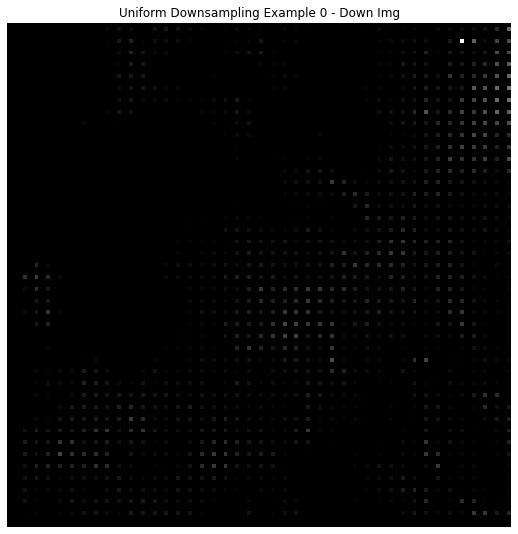

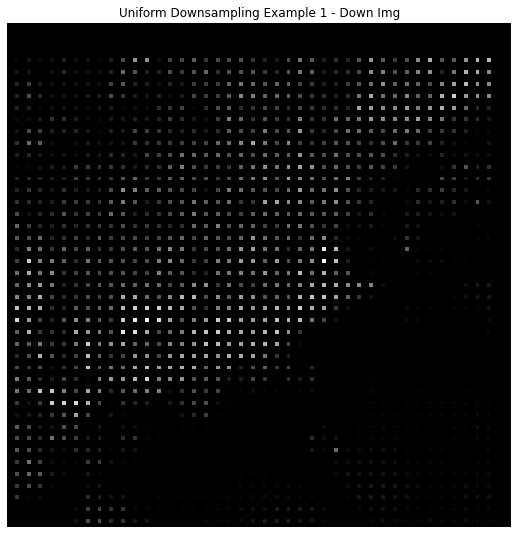

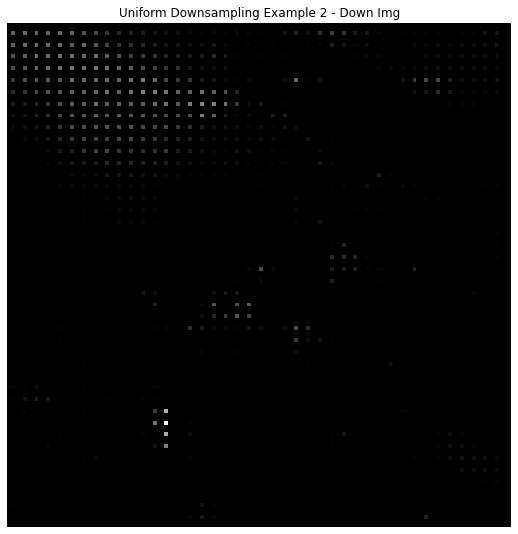

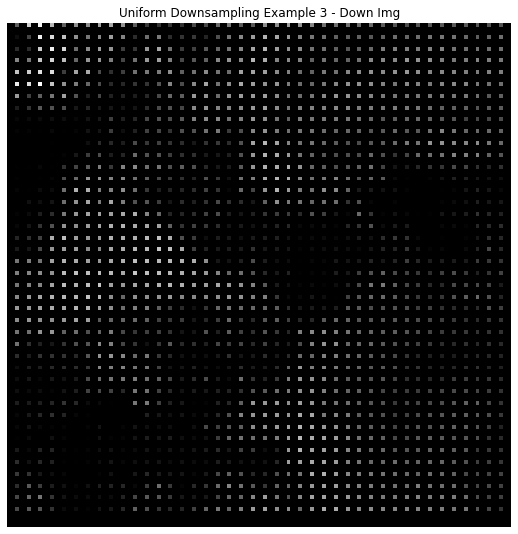

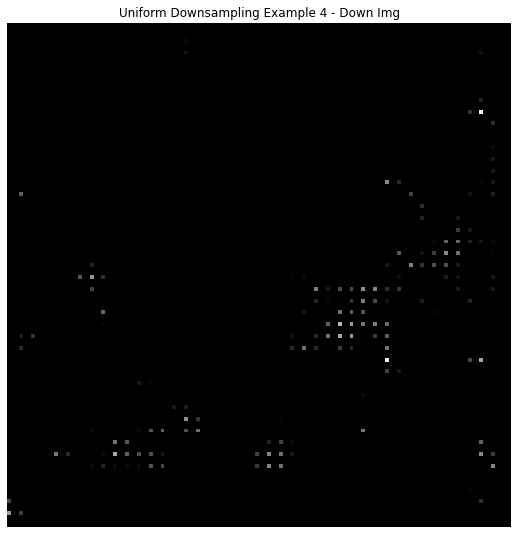

In [9]:
for i in range(5):
    img = (next(iter(train_ds_aug)))[...,1]
    figsize = (7,7)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(img, cmap = 'gray')
    plt.title(f'Uniform Downsampling Example {i} - Down Img')
    plt.show()

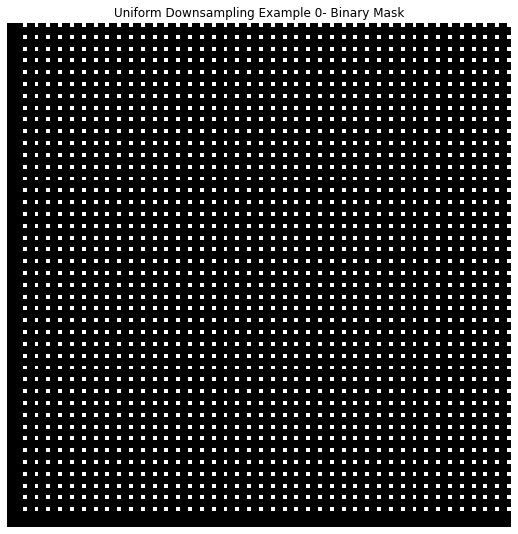

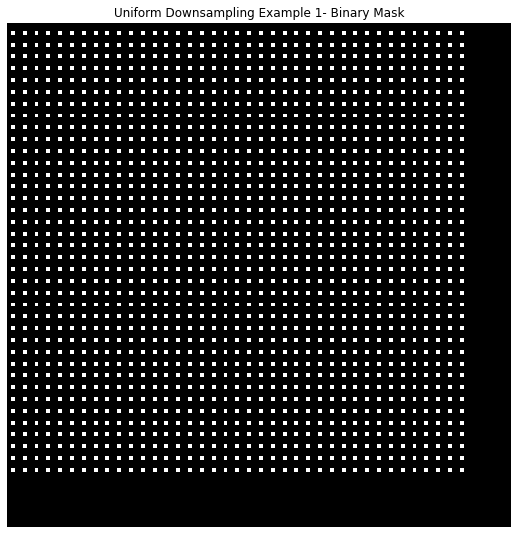

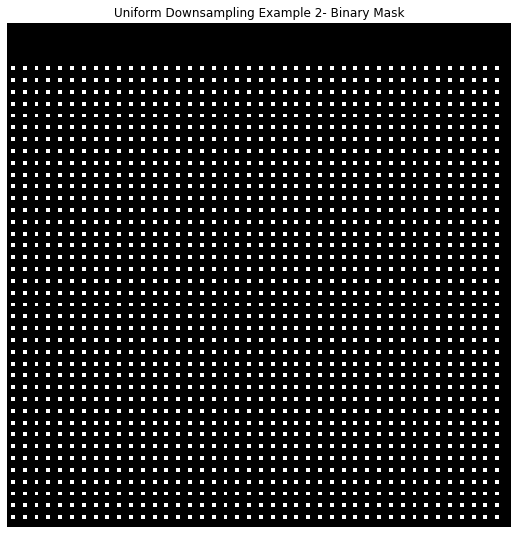

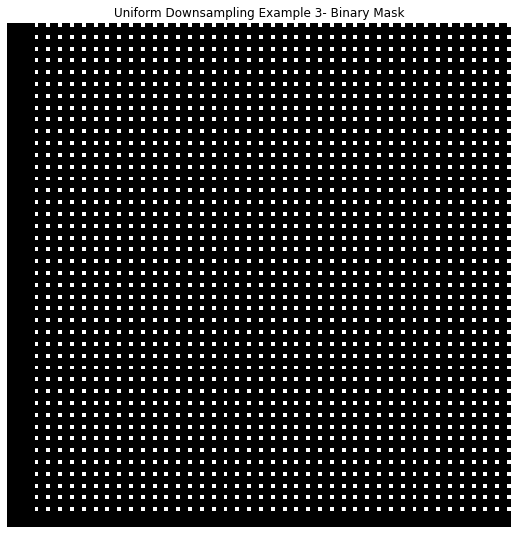

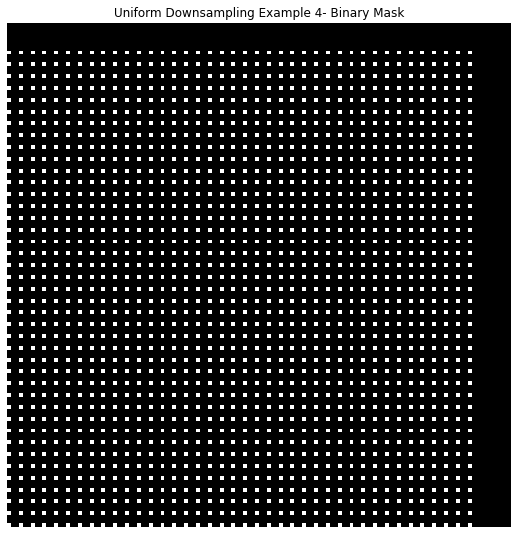

In [10]:
for i in range(5):
    img = (next(iter(train_ds_aug)))[...,2]
    figsize = (7,7)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(img, cmap = 'gray')
    plt.title(f'Uniform Downsampling Example {i}- Binary Mask')
    plt.show()

## Random Downsampling Method

In [11]:
SPARSITY = 1 - (1/9) # Higher Sparsity equals fewer pixels sampled

down_map_func = partial(downsample_zerofill, sparsity=SPARSITY, min_shape = (CROP_SIZE[0], CROP_SIZE[1]))
train_ds_down_zerofill_rand = train_ds.map(lambda x: tf.numpy_function(down_map_func, [x['image']], tf.float32), num_parallel_calls=AUTOTUNE).cache()
val_ds_down_zerofill_rand = val_ds.map(lambda x: tf.numpy_function(down_map_func, [x['image']], tf.float32), num_parallel_calls=AUTOTUNE).cache()

train_ds_aug_rand = (
    train_ds_down_zerofill_rand
    .map(rand_crop, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
    .map(main_augment, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
    .map(lambda_func, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)
val_ds_aug_rand = (
    val_ds_down_zerofill_rand
    .map(rand_crop, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
) 

### Showing Augmentation Result

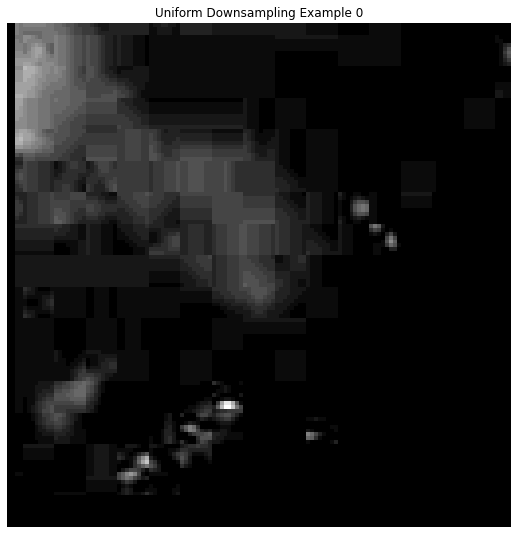

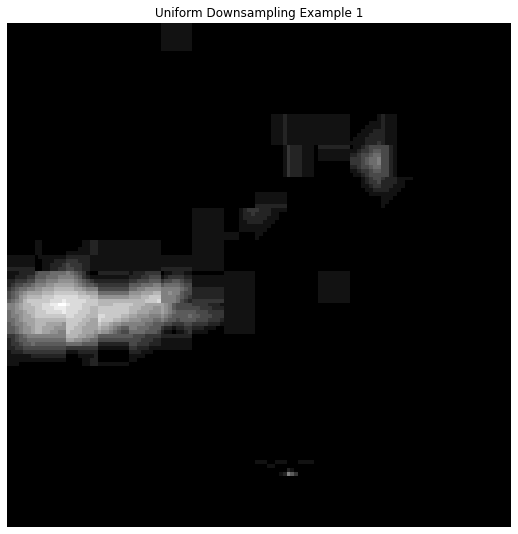

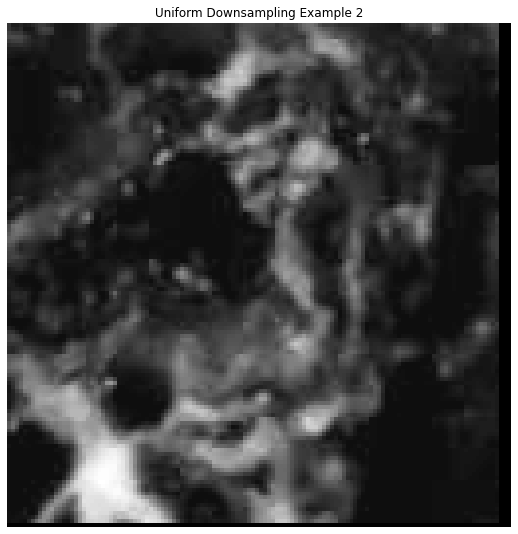

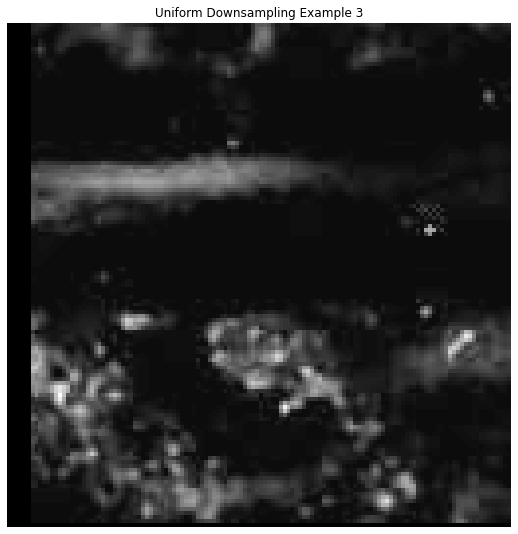

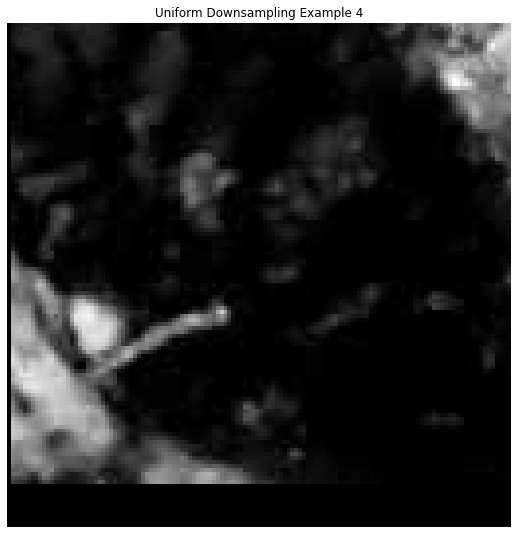

In [12]:
for i in range(5):
    img = (next(iter(train_ds_aug_rand)))[...,0]
    figsize = (7,7)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(img, cmap = 'gray')
    plt.title(f'Uniform Downsampling Example {i}')
    plt.show()

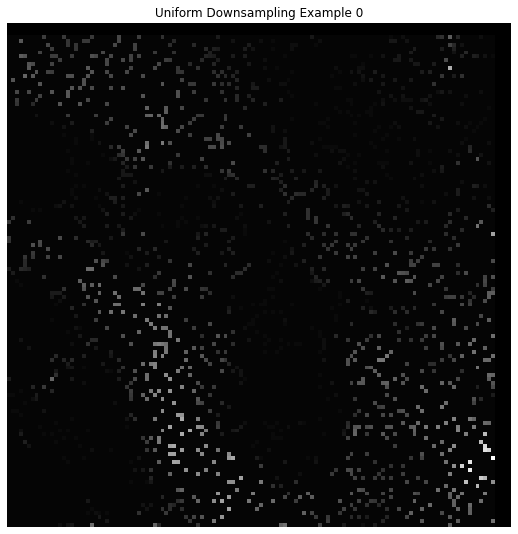

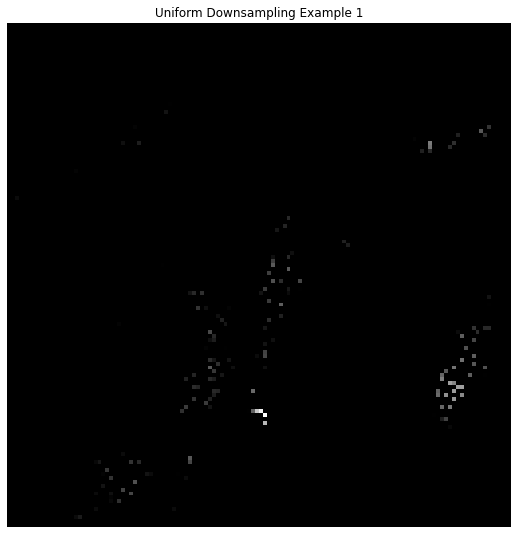

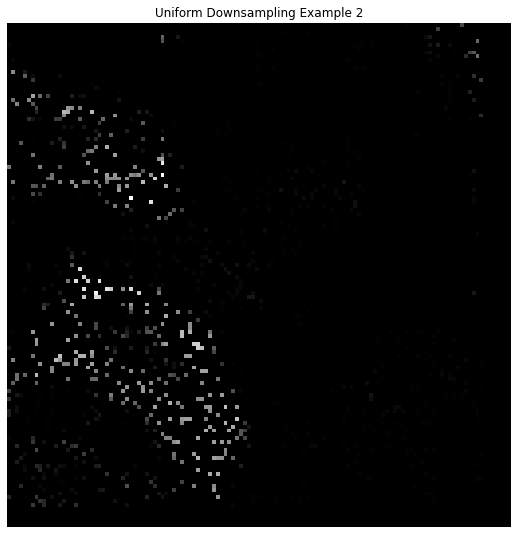

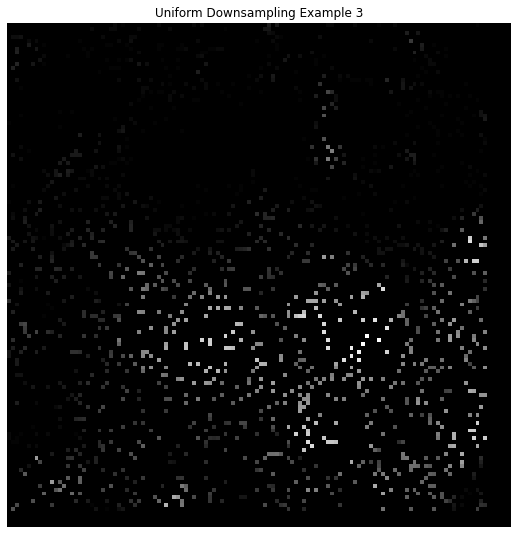

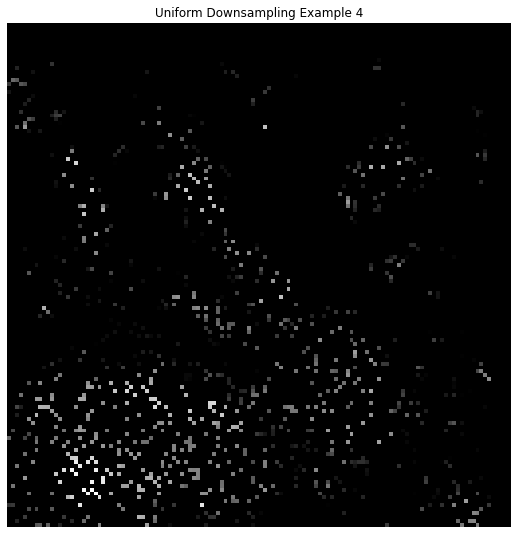

In [14]:
for i in range(5):
    img = (next(iter(train_ds_aug_rand)))[...,1]
    figsize = (7,7)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(img, cmap = 'gray')
    plt.title(f'Uniform Downsampling Example {i}')
    plt.show()

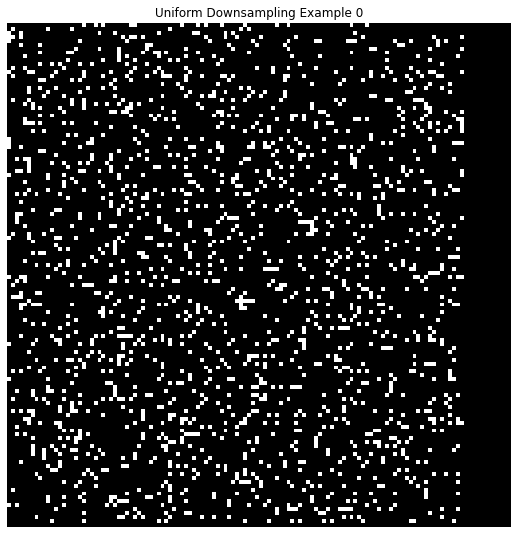

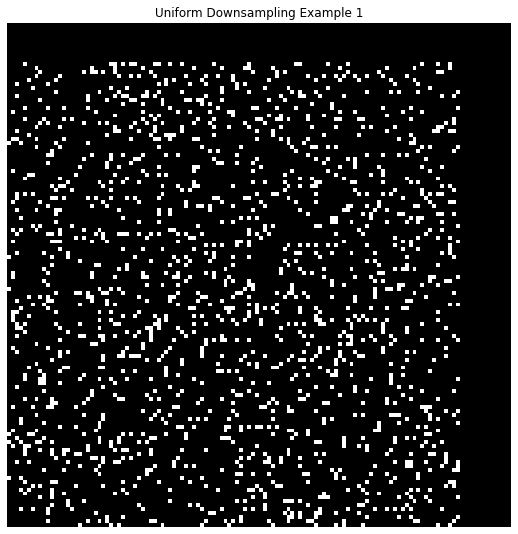

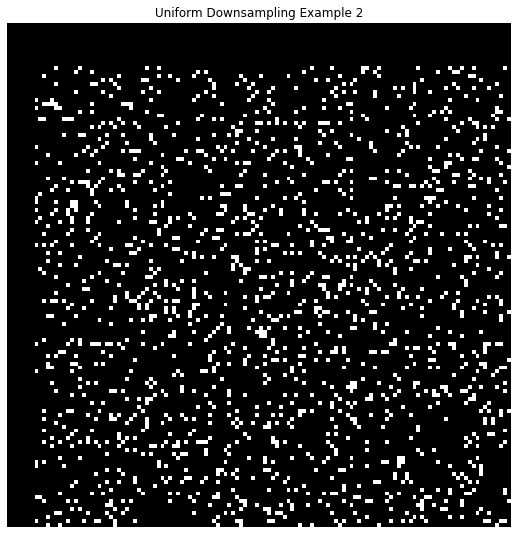

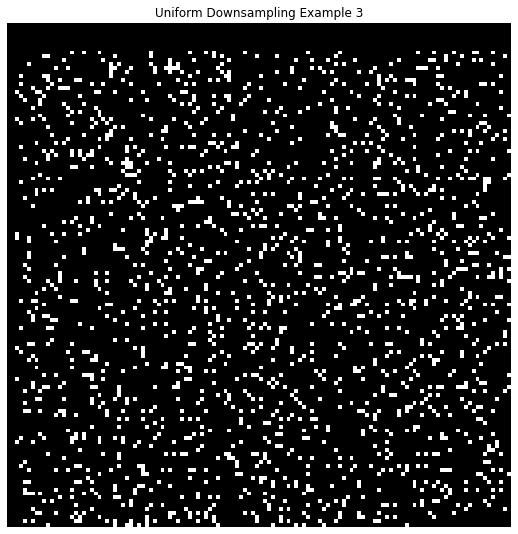

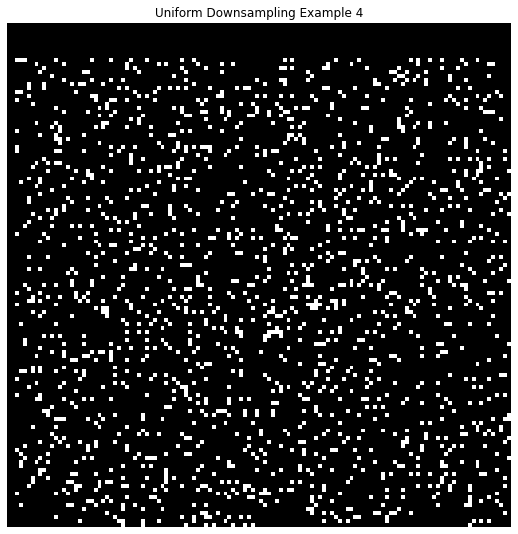

In [15]:
for i in range(5):
    img = (next(iter(train_ds_aug_rand)))[...,2]
    figsize = (7,7)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(img, cmap = 'gray')
    plt.title(f'Uniform Downsampling Example {i}')
    plt.show()